In [1]:
import numpy as np
import pandas as pd

import torch
import time
import copy
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, cross_val_score

import brevitas.nn as nn

from config import *
from classic_models import *
from data_preprocessing import *
from feature_extraction import *
from helpers import *

from torch.utils.data import DataLoader
from tslearn.preprocessing import TimeSeriesScalerMinMax

import warnings
warnings.filterwarnings("ignore")

['dab1_guiyong.json', 'dab1_john.json', 'dab1_kelvin.json', 'dab1_xiaoxue.json', 'dab2_guiyong.json', 'dab2_john.json', 'dab2_kelvin.json', 'dab2_xiaoxue.json', 'dab2_yujie.json', 'elbowkick1_guiyong.json', 'elbowkick1_john.json', 'elbowkick1_kelvin.json', 'elbowkick1_xiaoxue.json', 'elbowkick2_guiyong.json', 'elbowkick2_john.json', 'elbowkick2_kelvin.json', 'elbowkick2_xiaoxue.json', 'elbowkick2_yujie.json', 'gun1_guiyong.json', 'gun1_john.json', 'gun1_kelvin.json', 'gun1_xiaoxue.json', 'gun2_guiyong.json', 'gun2_john.json', 'gun2_kelvin.json', 'gun2_xiaoxue.json', 'gun2_yujie.json', 'hair1_guiyong.json', 'hair1_john.json', 'hair1_kelvin.json', 'hair1_xiaoxue.json', 'hair2_guiyong.json', 'hair2_john.json', 'hair2_kelvin.json', 'hair2_xiaoxue.json', 'hair2_yujie.json', 'listen1_guiyong.json', 'listen1_john.json', 'listen1_kelvin.json', 'listen1_xiaoxue.json', 'listen2_guiyong.json', 'listen2_john.json', 'listen2_kelvin.json', 'listen2_xiaoxue.json', 'listen2_yujie.json', 'pointhigh1_gu

In [2]:
from sklearn import preprocessing
df_train = pd.read_csv('out_6_train.csv')
# df_train = df_train.iloc[:, list(range(15,55)) + [-1]]
df_test = pd.read_csv('out_6_test.csv')
# df_test = df_test.iloc[:, list(range(15,55)) + [-1]]

df_train['tag'] = df_train['tag'].apply(lambda x: x-1)
df_test['tag'] = df_test['tag'].apply(lambda x: x-1)

df_train.head()
# print(window_size, overlap)

,mean_accel1,mean_accel2,mean_accel3,mean_gyro1,mean_gyro2,mean_gyro3,max_accel1,max_accel2,max_accel3,max_gyro1,...,var_coeff_gyro1,var_coeff_gyro2,var_coeff_gyro3,kurtosis_accel1,kurtosis_accel2,kurtosis_accel3,kurtosis_gyro1,kurtosis_gyro2,kurtosis_gyro3,tag
0,0.616378,0.854666,0.400104,0.614930,-0.006537,0.154084,0.287898,0.0,1.0,0.0,...,0.561611,-0.005166,0.099582,0.180983,0.0,3.0,0.08,0.177660,-1.347458,0.0
1,0.602017,0.854666,0.396410,0.569416,0.004897,0.158031,0.296461,0.0,1.0,0.0,...,0.469194,-0.006137,0.130340,0.162618,0.0,2.0,0.08,0.275087,-0.409847,0.0
2,0.671867,0.854666,0.396410,0.721344,0.007352,0.141179,0.247932,0.0,1.0,0.0,...,0.455569,-0.001540,0.112169,0.124111,0.0,1.0,0.12,0.251716,0.057590,0.0
3,0.699110,0.854666,0.396410,0.752908,-0.004695,0.129818,0.175135,0.0,2.0,0.0,...,0.455569,0.003839,0.133467,0.124111,0.0,1.0,0.12,0.289966,-0.092744,0.0
4,0.624511,0.813486,0.396410,0.654812,-0.007351,0.142739,0.291073,0.0,1.0,0.0,...,0.481043,0.002879,0.154154,0.208827,0.0,1.0,0.00,0.312800,-0.786469,0.0


In [3]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        if isinstance(df, pd.DataFrame):
            df_np = df.to_numpy()

        self.X = df_np[:,:-1]
        self.y = df_np[:,-1]

    def __getitem__(self, idx):
        # get item by index
        return self.X[idx], self.y[idx]

    def __len__(self):
        # returns length of data
        return len(self.X)

In [4]:
dataset = FeatureDataset(df_train)
D_in = 72 # df.shape[1]-1
D_out = 8 # len(dances)

In [5]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool1d, Module, Softmax, BatchNorm1d, Dropout, Flatten

class CNN(torch.nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(CNN, self).__init__()
        self.relu = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5)
        self.conv2 = torch.nn.Conv1d(in_channels=64,out_channels=64, kernel_size=5)
        self.conv3 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
        self.conv4 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
        self.conv5 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
        self.lstm1 = torch.nn.LSTM(
            input_size=14,
            hidden_size=32,
            num_layers=2,
            batch_first=False,
        )
        self.fc1 = torch.nn.Linear(52, 26)
        self.fc2 = torch.nn.Linear(26, d_out)
        
        self.dropout = torch.nn.Dropout(p=0.3) 
        
    def forward(self,x):
        x = x.float().unsqueeze(dim=1)
        x = self.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.relu(self.conv5(x))
#         x,_ = self.lstm1(x)
        x = x[:, -1]
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()

    def predict(self, X):
        outputs = self(X.float())
        _, predicted = torch.max(outputs, 1)
        return predicted

In [9]:
def train_val_model(model, criterion, optimizer, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    tscv = TimeSeriesSplit(n_splits=5, max_train_size=5000)
    kf = KFold(n_splits=10)
    X_train, X_test, y_train, y_test = train_test_split(
        dataset.X.reshape(dataset.X.shape[0],-1), dataset.y, test_size=0.1, random_state=42
    )
    confusion_matrix = torch.zeros(8, 8)

    for i in range(num_epochs):
        if log_interval is not None and i % log_interval == 0:
            print('Epoch {}/{}'.format(i, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
        # for fold, (train_index, test_index) in enumerate(tscv.split(X_train, y_train)):
        for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
            ### Dividing data into folds
            # train_index = train_index[len(train_index)-500:]
            x_train_fold = X_train[train_index]
            x_test_fold = X_train[test_index]
            y_train_fold = y_train[train_index]
            y_test_fold = y_train[test_index]

            print('Train Index Length:', len(x_train_fold), end='\t\t')
            print('Test Index Length:', len(x_test_fold), end='\n\n')

            train = torch.utils.data.TensorDataset(torch.tensor(x_train_fold), torch.tensor(y_train_fold))
            test = torch.utils.data.TensorDataset(torch.tensor(x_test_fold), torch.tensor(y_test_fold))
            train_loader = torch.utils.data.DataLoader(train, batch_size = 20, shuffle = False)
            test_loader = torch.utils.data.DataLoader(test, batch_size = 20, shuffle = False)

            running_loss = 0.0
            running_corrects = 0
            model.train()
            for batch_index, (x_batch, y_batch) in enumerate(train_loader):
                optimizer.zero_grad()
                y_pred = model(x_batch)
                _, preds = torch.max(y_pred, 1)
                for t, p in zip(y_batch.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1
                single_loss = criterion(y_pred, y_batch.long().view(-1))
                single_loss.backward()
                optimizer.step()
                
                running_loss += single_loss.item() * x_batch.size(0)
                running_corrects += torch.sum(preds == y_batch.data)
            print('Fold No. {}/{}\tEpoch {}/{}\t'.format(fold + 1 , kf.get_n_splits(X_train), i + 1, num_epochs), end='')
            print(f'loss: {single_loss.item():10.8f}')
            
            nsamples = len(train_index)
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and i % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))
    print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    return model, losses, accuracies

In [10]:
model = CNN(D_in, 70, D_out)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

torch.Size([64, 1, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([128, 14])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([26, 52])
torch.Size([26])
torch.Size([8, 26])
torch.Size([8])
Total number of parameters = 98746


In [11]:
NUM_EPOCHS = 1
model, losses, accuracies = train_val_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS, log_interval=1)

Epoch 0/0
----------
Train Index Length: 7038		Test Index Length: 783

Fold No. 1/10	Epoch 1/1	loss: 1.98468614
val Loss: 2.0716 Acc: 14.32%
Train Index Length: 7039		Test Index Length: 782

Fold No. 2/10	Epoch 1/1	loss: 1.63191819
val Loss: 1.8436 Acc: 29.52%
Train Index Length: 7039		Test Index Length: 782

Fold No. 3/10	Epoch 1/1	loss: 1.56723261
val Loss: 1.6468 Acc: 36.97%
Train Index Length: 7039		Test Index Length: 782

Fold No. 4/10	Epoch 1/1	loss: 1.48336601
val Loss: 1.5055 Acc: 42.56%
Train Index Length: 7039		Test Index Length: 782

Fold No. 5/10	Epoch 1/1	loss: 1.33853602
val Loss: 1.4018 Acc: 47.17%
Train Index Length: 7039		Test Index Length: 782

Fold No. 6/10	Epoch 1/1	loss: 1.09055805
val Loss: 1.3243 Acc: 49.71%
Train Index Length: 7039		Test Index Length: 782

Fold No. 7/10	Epoch 1/1	loss: 1.16145468
val Loss: 1.2501 Acc: 53.57%
Train Index Length: 7039		Test Index Length: 782

Fold No. 8/10	Epoch 1/1	loss: 0.99794918
val Loss: 1.1798 Acc: 54.55%
Train Index Length:

In [12]:
NUM_EPOCHS = 15
overlap = 48
window_size = 50

In [13]:
name = f'CNN_Model_moves_{D_out}_ws{window_size}_ol{overlap}_epoch{NUM_EPOCHS}'
torch.save(model.state_dict(), name)

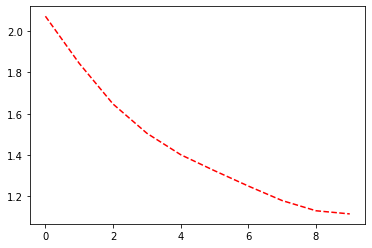

In [14]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [15]:
cnn_model = CNN(D_in, 70, D_out)
cnn_model.load(name)
cnn_model.eval()

for to_predict in range(D_out):
    df_target = df_test[df_test['tag'] == to_predict]

    df_random = df_test

    df_filtered = torch.from_numpy(np.array(pd.merge(df_target, df_random))[:,:-1])
    output = cnn_model.predict(df_filtered)
    # print(output)
    proba_dict = {}

    for x in output:
        x = int(x)
        if x not in proba_dict:
            proba_dict[x] = 1
        else:
            proba_dict[x] += 1
    for k in proba_dict.keys():
        proba_dict[k] /= len(output)

    print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

{0: 0.6632653061224489, 5: 0.1836734693877551, 6: 0.05612244897959184, 7: 0.04591836734693878, 1: 0.030612244897959183, 3: 0.015306122448979591, 2: 0.00510204081632653}
{1: 0.6547085201793722, 5: 0.08520179372197309, 4: 0.07623318385650224, 6: 0.07174887892376682, 3: 0.04484304932735426, 0: 0.04484304932735426, 2: 0.017937219730941704, 7: 0.004484304932735426}
{2: 0.49074074074074076, 1: 0.3055555555555556, 3: 0.07407407407407407, 6: 0.037037037037037035, 5: 0.037037037037037035, 0: 0.027777777777777776, 4: 0.018518518518518517, 7: 0.009259259259259259}
{3: 0.3691588785046729, 4: 0.2336448598130841, 0: 0.21962616822429906, 5: 0.12149532710280374, 1: 0.03271028037383177, 6: 0.014018691588785047, 2: 0.009345794392523364}
{4: 0.4611872146118721, 3: 0.1095890410958904, 0: 0.1050228310502283, 6: 0.0867579908675799, 1: 0.0821917808219178, 2: 0.0821917808219178, 7: 0.0365296803652968, 5: 0.0365296803652968}
{5: 0.8251121076233184, 0: 0.1210762331838565, 7: 0.026905829596412557, 6: 0.013452914

In [17]:
def feature_extract(df, window_size):
    full_features = np.array([])
    axis = ['accel1', 'accel2', 'accel3', 'gyro1', 'gyro2', 'gyro3']
    titles = np.ravel(np.array([i+'_'+j for i in feature_list for j in axis]))

    # print("Begin Feature Extraction")
    windows = set_sliding_windows(df, 40, window_size)
    # windows = set_windows(df, window_size)

    for window in windows:
        for _,ax in enumerate(window.T):
                full_features = np.append(full_features, add_mean(ax))
                full_features = np.append(full_features, add_max(ax))
                full_features = np.append(full_features, add_min(ax))
                full_features = np.append(full_features, add_median(ax))
                full_features = np.append(full_features, add_gradient(ax))
                full_features = np.append(full_features, add_std(ax))
                full_features = np.append(full_features, add_iqr(ax))
                # full_features = np.append(full_features, add_skew(ax))
                full_features = np.append(full_features, add_zero_crossing_count(ax))
                # full_features = np.append(full_features, add_cwt(ax))
                full_features = np.append(full_features, add_no_peaks(ax))
                full_features = np.append(full_features, add_recurring_dp(ax))
                # full_features = np.append(full_features, add_ratio_v_tsl(ax))
                # full_features = np.append(full_features, add_sum_recurring_dp(ax))
                full_features = np.append(full_features, add_var_coeff(ax))
                full_features = np.append(full_features, add_kurtosis(ax)) 

    full_features = full_features.reshape(
        -1,
        len(feature_list) * 6,
    )   
    full_features_df = pd.DataFrame(full_features)
    full_features_df.columns = titles
    return full_features_df

def feature_extraction(data):
    data = pd.DataFrame.from_dict(data)
    if 'dance' in data:
        del data['dance']

    df = data.apply(pd.to_numeric).interpolate(method='polynomial', order=2)
    col = df.columns
    # X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)
    df_scaled = df.apply(lambda x: (x - min(x)) / (max(x) - min(x)))
    # min_max_scaler = preprocessing.MinMaxScaler()
    # df_scaled = min_max_scaler.fit_transform(df)
    df = pd.DataFrame(df_scaled, columns=col)
    df.reset_index(drop=True, inplace=True)

    print(df.shape)
    features = feature_extract(df, window_size=50).reset_index(drop=True)
    # print(features.shape)
    return features

In [18]:
import json

dances = ['dab', 'elbowkick', 'gun', 'hair', 'listen', 'pointhigh', 'sidepump', 'wipetable']
# dances = ['gun', 'hair', 'sidepump']
# dances = ['elbowkick', 'pointhigh', 'wipetable']
persons = ['kelvin', 'guiyong', 'xiaoxue', 'john']
beetles = ['1', '2']

test_range = 12
leap = 100
truth, total, skipped = 0,0,0
for i in range(18,18+test_range):
    print("Phase:", i)
    start, end = i * leap, i * leap + leap
    for d in dances:
        print(d)
        df_full = pd.DataFrame()
        collection = [np.array([]) for x in range(16)]
        j = 0
        for p in persons:
            for b in beetles:
                if b == '2':
                    continue
                move_json = 'collected_data/' + d + b + '_' + p + '.json'
                with open(move_json) as f:
                    x = json.load(f)
                x = pd.DataFrame.from_dict(x)[1500:1600]
                df_target = torch.from_numpy(np.array(feature_extraction(x)))
                output = cnn_model.predict(df_target)
                proba_dict = {}

                for x in output:
                    x = int(x)
                    if x not in proba_dict:
                        proba_dict[x] = 1
                    else:
                        proba_dict[x] += 1
                for k in proba_dict.keys():
                    proba_dict[k] /= len(output)

                print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

Phase: 18
dab
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 1.0}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 0.8333333333333334, 0: 0.16666666666666666}
(100, 6)
Set sliding windows: 6
Sliding: 0
{0: 1.0}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 0.6666666666666666, 0: 0.3333333333333333}
elbowkick
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 1.0}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 1.0}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 0.6666666666666666, 2: 0.3333333333333333}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 0.6666666666666666, 0: 0.3333333333333333}
gun
(100, 6)
Set sliding windows: 6
Sliding: 0
{2: 0.3333333333333333, 1: 0.3333333333333333, 6: 0.16666666666666666, 5: 0.16666666666666666}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 0.6666666666666666, 2: 0.3333333333333333}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 1.0}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 0.8333333333333334, 2: 0.16666666666666666}
hair
(100, 6)
Set sliding window

(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 0.6666666666666666, 0: 0.3333333333333333}
elbowkick
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 1.0}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 1.0}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 0.6666666666666666, 2: 0.3333333333333333}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 0.6666666666666666, 0: 0.3333333333333333}
gun
(100, 6)
Set sliding windows: 6
Sliding: 0
{2: 0.3333333333333333, 1: 0.3333333333333333, 6: 0.16666666666666666, 5: 0.16666666666666666}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 0.6666666666666666, 2: 0.3333333333333333}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 1.0}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 0.8333333333333334, 2: 0.16666666666666666}
hair
(100, 6)
Set sliding windows: 6
Sliding: 0
{0: 0.6666666666666666, 5: 0.3333333333333333}
(100, 6)
Set sliding windows: 6
Sliding: 0
{0: 0.8333333333333334, 5: 0.16666666666666666}
(100, 6)
Set sliding windows: 6
Sliding: 0
{5: 0.666666

KeyboardInterrupt: 

In [ ]:
dataset.df.head()